In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df = pd.read_csv("processed_kelulusan.csv")
df.head()

,IPK,Jumlah_Absensi,Waktu_Belajar_Jam,Lulus,Rasio_Absensi,IPK_x_Study
0,3.8,3,10,1,0.214286,38.0
1,2.5,8,5,0,0.571429,12.5
2,3.4,4,7,1,0.285714,23.8
3,2.1,12,2,0,0.857143,4.2
4,3.9,2,12,1,0.142857,46.8


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("processed_kelulusan.csv")
X = df.drop("Lulus", axis=1)
y = df["Lulus"]

#Ganti pembagian data agar tidak error karena dataset kecil
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42  # stratify dipakai sekali saja
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42 #tanpa stratify
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (4, 5)
Validation: (3, 5)
Test: (3, 5)


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

num_cols = X_train.select_dtypes(include="number").columns

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
], remainder="drop")

logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
pipe_lr = Pipeline([("pre", pre), ("clf", logreg)])

pipe_lr.fit(X_train, y_train)
y_val_pred = pipe_lr.predict(X_val)
print("Baseline (LogReg) F1(val):", f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred, digits=3))

Baseline (LogReg) F1(val): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         2

    accuracy                          1.000         3
   macro avg      1.000     1.000     1.000         3
weighted avg      1.000     1.000     1.000         3



In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300, max_features="sqrt", class_weight="balanced", random_state=42
)
pipe_rf = Pipeline([("pre", pre), ("clf", rf)])

pipe_rf.fit(X_train, y_train)
y_val_rf = pipe_rf.predict(X_val)
print("RandomForest F1(val):", f1_score(y_val, y_val_rf, average="macro"))

RandomForest F1(val): 1.0


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score

# Pipeline Random Forest
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Grid Search + Cross Validation
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

param = {
  "clf__max_depth": [None, 12, 20, 30],
  "clf__min_samples_split": [2, 5, 10]
}

gs = GridSearchCV(pipe_rf, param_grid=param, cv=skf,
                  scoring="f1_macro", n_jobs=-1, verbose=1)

# Latih model dengan data train
gs.fit(X_train, y_train)

# Tampilkan hasil terbaik
print("Best params:", gs.best_params_)
print("Best CV F1:", gs.best_score_)

# Uji model terbaik di validation set
best_rf = gs.best_estimator_
y_val_best = best_rf.predict(X_val)
print("Best RF F1(val):", f1_score(y_val, y_val_best, average="macro"))


Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2}
Best CV F1: 0.3333333333333333
Best RF F1(val): 1.0


F1(test): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      1.000     1.000     1.000         1

    accuracy                          1.000         3
   macro avg      1.000     1.000     1.000         3
weighted avg      1.000     1.000     1.000         3

Confusion matrix (test):
[[2 0]
 [0 1]]
ROC-AUC(test): 1.0


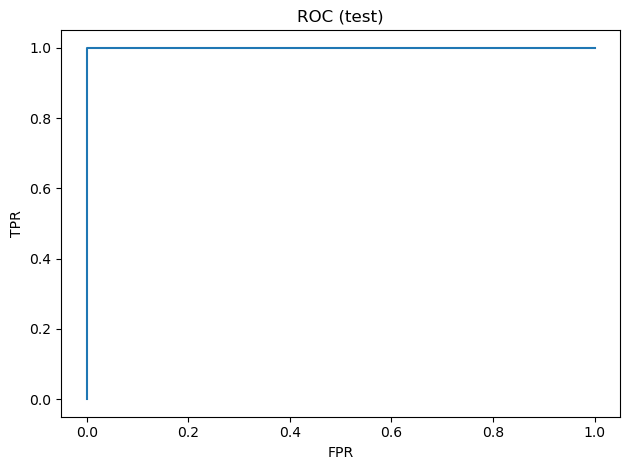

In [26]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

final_model = best_rf  # atau pipe_lr jika baseline lebih baik
y_test_pred = final_model.predict(X_test)

print("F1(test):", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred, digits=3))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

# ROC-AUC (jika ada predict_proba)
if hasattr(final_model, "predict_proba"):
    y_test_proba = final_model.predict_proba(X_test)[:,1]
    try:
        print("ROC-AUC(test):", roc_auc_score(y_test, y_test_proba))
    except:
        pass
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
    plt.tight_layout(); plt.savefig("roc_test.png", dpi=120)

In [27]:
import joblib
joblib.dump(final_model, "model.pkl")
print("Model tersimpan ke model.pkl")

Model tersimpan ke model.pkl
